In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet

#feature importance
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

#Set random seed to current date and time to get a pseudorandom state
import random
from datetime import datetime
random.seed(datetime.now()) 

#This is to round the output to 3 decimal places when printing outputs
np.set_printoptions(precision=3)

#Import dataset
data = pd.read_csv("C:/Users/kimng/Desktop/ML - Age, Hipp, CVLT/CVLTHippocampus.csv")
data = data.reset_index(drop=True)

In [2]:
#Select columns to be used for analyses
columns = ['CVLT_Imm_Total', 'CVLT_DelR_SD_Free', 'CVLT_DelR_LD_Free',
            'Age','Sex', 'EduYears', 'Smoker', 'High_BP', 'COMT', 'BDNF2', 'ApoE4',
           'L_HH_Total', 'R_HH_Total', 'L_HB_Total', 'R_HB_Total', 'L_HT_Total', 'R_HT_Total',
           'L_DG_Total', 'R_DG_Total',
           'L_CA_Total', 'R_CA_Total',
           'L_Sub_Total', 'R_Sub_Total',
           'L_HH_CA', 'R_HH_CA', 'L_HB_CA', 'R_HB_CA', 'L_HT_CA', 'R_HT_CA', 
           'L_HH_DG', 'R_HH_DG', 'L_HB_DG', 'R_HB_DG', 'L_HT_DG', 'R_HT_DG',
           'L_HH_Sub', 'R_HH_Sub', 'L_HB_Sub', 'R_HB_Sub', 'L_HT_Sub', 'R_HT_Sub']

#Subset data
df = data[columns]

In [3]:
# drop missing data list-wise
df.dropna(inplace=True)

#reset index -- this is to replace old data index with index based on current data.
df = df.reset_index(drop=True)

# get new data dimension
df.shape 

(129, 41)

In [4]:
df.Sex = df.Sex-1 #Change Sex from 1(male),2 (female) to 0 (Male),1 (Female)

In [5]:
#Bin Age into groups
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = [1,2,3,4,5,6,7,8]
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
df = df.reset_index(drop=True)

#Function for categorise dataframe
def categorise(row):
    if row['AgeGroup'] == 1 and row['Sex'] == 0:
        return 1
    elif row['AgeGroup'] == 1 and row['Sex'] == 1:
        return 2
    elif row['AgeGroup'] == 2 and row['Sex'] == 0:
        return 3
    elif row['AgeGroup'] == 2 and row['Sex'] == 1:
        return 4
    elif row['AgeGroup'] == 3 and row['Sex'] == 0:
        return 5
    elif row['AgeGroup'] == 3 and row['Sex'] == 1:
        return 6
    elif row['AgeGroup'] == 4 and row['Sex'] == 0:
        return 7
    elif row['AgeGroup'] == 4 and row['Sex'] == 1:
        return 8
    elif row['AgeGroup'] == 5 and row['Sex'] == 0:
        return 9
    elif row['AgeGroup'] == 5 and row['Sex'] == 1:
        return 10
    elif row['AgeGroup'] == 6 and row['Sex'] == 0:
        return 11
    elif row['AgeGroup'] == 6 and row['Sex'] == 1:
        return 12
    elif row['AgeGroup'] == 7 and row['Sex'] == 0:
        return 13
    elif row['AgeGroup'] == 7 and row['Sex'] == 1:
        return 14
    elif row['AgeGroup'] == 8 and row['Sex'] == 0:
        return 15
    elif row['AgeGroup'] == 8 and row['Sex'] == 1:
        return 16


#Apply categories to dataframe
df['grp'] = df.apply(lambda row: categorise(row), axis=1)

In [6]:
df.describe()

,CVLT_Imm_Total,CVLT_DelR_SD_Free,CVLT_DelR_LD_Free,Age,Sex,EduYears,Smoker,High_BP,COMT,BDNF2,...,R_HB_DG,L_HT_DG,R_HT_DG,L_HH_Sub,R_HH_Sub,L_HB_Sub,R_HB_Sub,L_HT_Sub,R_HT_Sub,grp
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,54.775194,11.666667,12.248062,47.635659,0.542636,15.860465,1.031008,1.116279,2.062016,1.666667,...,312.167117,215.278658,216.086355,270.114788,286.853054,216.401042,208.797596,26.868606,29.594662,8.054264
std,9.126062,2.608080,2.613161,18.883251,0.500121,2.461403,0.174014,0.321809,0.736885,0.473242,...,56.639130,55.946779,57.863672,54.831992,53.460985,41.213681,35.336911,6.789627,8.055470,3.863511
min,35.000000,6.000000,5.000000,18.000000,0.000000,10.000000,1.000000,1.000000,1.000000,1.000000,...,173.639405,89.231806,89.795907,148.819290,158.846793,110.909966,106.781205,12.233782,15.553328,1.000000
25%,49.000000,10.000000,10.000000,30.000000,0.000000,14.000000,1.000000,1.000000,2.000000,1.000000,...,271.435985,174.712057,181.698029,229.770510,254.843688,186.129439,187.518921,22.200925,24.290453,4.000000
50%,55.000000,12.000000,12.000000,48.000000,1.000000,16.000000,1.000000,1.000000,2.000000,2.000000,...,313.215662,213.735190,209.295573,265.785139,285.320587,215.537167,209.140882,24.817369,28.900795,8.000000
75%,61.000000,14.000000,14.000000,64.000000,1.000000,17.000000,1.000000,1.000000,3.000000,2.000000,...,349.277249,254.920021,254.615139,310.839873,317.390520,243.406118,230.304132,31.469792,33.466886,11.000000
max,73.000000,16.000000,16.000000,85.000000,1.000000,23.000000,2.000000,2.000000,3.000000,2.000000,...,455.998451,352.813403,363.037216,433.877967,494.619458,332.358149,305.395180,46.911832,55.632057,16.000000


In [7]:
#Initialize Regressor
model = ElasticNet()

#Set up parameter grid
param_grid = [{'alpha': np.arange(0.01, 2.01, 0.01)}]

#Set up GridSearchCV
search = GridSearchCV(estimator=model, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error', #use MSE for model selection (larger neg-MSE = better model)
                      cv = 3, 
                      n_jobs = 1, 
                      refit = True)

# Predicting Immediate Recall

### Model 1 -- Demographic and genetic variables as predictors

In [19]:
# Empty list to store evaluation metrics
outer_train_mae = []
outer_train_mse = []
outer_train_rmse = []
outer_train_corelation = []
outer_train_r2 = []

outer_test_mae = []
outer_test_mse = []
outer_test_rmse = []
outer_test_corelation = []
outer_test_r2 = []

coefficients_df = pd.DataFrame()


feature_names = ['Age','Sex', 'EduYears', 'COMT', 'BDNF2', 'ApoE4'
                 ]
target = ['CVLT_Imm_Total']

# Feature Scaling
scaler = MinMaxScaler()
df[feature_names] = scaler.fit_transform(df[feature_names])

# configure the cross-validation procedure
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

#fold counter
fold_no = 1

# Loop through each outer CV fold
for train_index_outer, test_index_outer in outer_cv.split(df, df.grp):
    train_set = df.loc[train_index_outer,:]
    test_set = df.loc[test_index_outer,:]

    X_train = train_set[feature_names]
    y_train = train_set[target]
    X_test = test_set[feature_names]
    y_test = test_set[target]
    
        
    print("\n Results for outer loop fold ", fold_no)
    fold_no = fold_no+1
        
    
    #Print out memory performance to ensure similar distribution across folds
#    plt.figure()
#    plt.subplot(1, 2, 1) 
#    plt.hist(y_train, bins=10)
#    plt.hist(y_test, bins=10)
#    plt.title("Memory Score Distribution")
    
#    plt.subplot(1, 2, 2)
#    plt.hist(X_train.Age, bins=10)
#    plt.hist(X_test.Age, bins=10)
#    plt.title("Age Distribution")
#    plt.show()
    
    #Apply grid search with CV=3 on outer train_set (this is hyperparameter tuning process within the inner loop)
    search.fit(X = X_train, y = y_train) # run inner loop hyperparam tuning

    print('        Best MSE (across all inner validation folds):', abs(search.best_score_))
    print('        Best parameters:', search.best_params_)
    
    #Best model based on grid search
    best_model = search.best_estimator_
   
    #Inner Train set performance
    #This is to compare with performance on the test set and identify fitting issues
    #Predict train set
    y_train_hat = best_model.predict(X_train)
    
    #MSE
    mse_train = mean_squared_error(y_train, y_train_hat)
    outer_train_mse.append(mse_train)
    print('\n        MSE (on outer training set)', mse_train)
    
    #RMSE
    rmse_train = np.sqrt(mse_train)
    outer_train_rmse.append(rmse_train)
    print('        RMSE (on outer training set)', (outer_train_rmse[-1]))

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_hat)
    outer_train_mae.append(mae_train)          
    print('        MAE (on outer training set)', (outer_train_mae[-1]))
         
    # R2
    r2_train = r2_score(y_train, y_train_hat)
    outer_train_r2.append(r2_train)    
    print('        R2 (on outer training set)', (outer_train_r2[-1]))
    
    #Correlation between true vs predicted
    y_train_array = np.array(y_train).reshape(1,len(y_train))
    y_train_hat_array = pd.DataFrame(y_train_hat)
    y_train_hat_array = np.array(y_train_hat_array).reshape(1,len(y_train_hat))
    corelation_true_pred_train = np.corrcoef(y_train_array, y_train_hat_array)[0,1]
    outer_train_corelation.append(corelation_true_pred_train)          
    print('        Correlation between Predicted and actual values (on outer training set)', (outer_train_corelation[-1]))
    
    
    ######## EVALUATE ON OUTER TEST SET ########
    #Predict y_test based on best model
    y_test_hat = best_model.predict(X_test)
    
    # Calculate evaluation metrics using best-tuned model on the outer val_set  
    #MSE
    mse_test = mean_squared_error(y_test, y_test_hat)
    outer_test_mse.append(mse_test)
    print('\n        MSE (on outer test set)', (outer_test_mse[-1]))
    
    #RMSE
    rmse_test = np.sqrt(mse_test)
    outer_test_rmse.append(rmse_test)
    print('        RMSE (on outer test set)', (outer_test_rmse[-1]))

    # MAE
    mae_test = mean_absolute_error(y_test, y_test_hat)
    outer_test_mae.append(mae_test)          
    print('        MAE (on outer test set)', (outer_test_mae[-1]))
         
    # R2
    r2_test = r2_score(y_test, y_test_hat)
    outer_test_r2.append(r2_test)    
    print('        R2 (on outer test set)', (outer_test_r2[-1]))
    
    #Correlation between true vs predicted
    y_test_array = np.array(y_test).reshape(1,len(y_test))
    y_test_hat_array = pd.DataFrame(y_test_hat)
    y_test_hat_array = np.array(y_test_hat_array).reshape(1,len(y_test_hat))
    corelation_true_pred = np.corrcoef(y_test_array, y_test_hat_array)[0,1]
    outer_test_corelation.append(corelation_true_pred)          
    print('        Correlation between Predicted and actual values (on outer test set)', (outer_test_corelation[-1]))
    
    
    ######## COEFFICIENTS #########   
    coefficients = best_model.coef_

    #Create df column for coefficients
    column_name = 'Feature Importance '+ str(fold_no-1)
    coefficients_df[column_name] = coefficients
    
    
# Print evaluation metrics across all outer loop folds
print('\n    Average performance across all outer test sets:')
print('        MSE %.2f +/- %.2f'% (np.mean(outer_test_mse), np.std(outer_test_mse)))
print('        RMSE %.2f +/- %.2f'% (np.mean(outer_test_rmse), np.std(outer_test_rmse)))
print('        MAE %.2f +/- %.2f'% (np.mean(outer_test_mae), np.std(outer_test_mae)))
print('        R2 %.2f +/- %.2f'% (np.mean(outer_test_r2), np.std(outer_test_r2)))
print('        Correlation %.2f +/- %.2f'% (np.mean(outer_test_corelation), np.std(outer_test_corelation)))



 Results for outer loop fold  1
        Best MSE (across all inner validation folds): 59.53011656299142
        Best parameters: {'alpha': 0.01}

        MSE (on outer training set) 51.900191986153736
        RMSE (on outer training set) 7.204178786381814
        MAE (on outer training set) 5.92819139509259
        R2 (on outer training set) 0.3056070896250075
        Correlation between Predicted and actual values (on outer training set) 0.553582545477421

        MSE (on outer test set) 70.44732515533184
        RMSE (on outer test set) 8.393290484388816
        MAE (on outer test set) 7.223280559267608
        R2 (on outer test set) 0.3584395343463562
        Correlation between Predicted and actual values (on outer test set) 0.6459784573420252

 Results for outer loop fold  2
        Best MSE (across all inner validation folds): 55.437117210024134
        Best parameters: {'alpha': 0.01}

        MSE (on outer training set) 50.265023109558314
        RMSE (on outer training set) 7

In [20]:
#Feature Importance Dataframe

coefficients_df = coefficients_df.set_index(X_train.columns)
coefficients_df["Mean Coefficient Value"] = coefficients_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].mean(axis=1)
coefficients_df["SD Coefficient Value"] = coefficients_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].std(axis=1)
coefficients_df["Feature Importance"] = coefficients_df["Mean Coefficient Value"].abs()

#Sort by mean importance
coefficients_df = coefficients_df.sort_values(by=["Feature Importance"], ascending = False)
coefficients_df

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Coefficient Value,SD Coefficient Value,Feature Importance
Age,-10.835035,-12.687056,-11.268161,-14.987355,-14.276619,-12.810845,1.815538,12.810845
EduYears,5.649208,12.108177,7.727856,6.324041,6.128276,7.587512,2.642861,7.587512
Sex,6.428931,6.230901,6.988319,4.856792,6.401314,6.181252,0.793377,6.181252
ApoE4,-1.866903,-5.806771,-1.713920,-1.743689,-2.628648,-2.751986,1.748180,2.751986
COMT,-0.927403,-2.861448,-0.998010,-2.897509,-3.156849,-2.168244,1.106665,2.168244
BDNF2,-2.270301,-2.016240,-0.941920,-0.892166,-0.446831,-1.313492,0.786769,1.313492


### Model 2 -- adding hippocampal volumes as predictors

In [8]:
# Empty list to store evaluation metrics
outer_train_mae = []
outer_train_mse = []
outer_train_rmse = []
outer_train_corelation = []
outer_train_r2 = []

outer_test_mae = []
outer_test_mse = []
outer_test_rmse = []
outer_test_corelation = []
outer_test_r2 = []

coefficients_df = pd.DataFrame()


feature_names = ['Age','Sex', 'EduYears', 'COMT', 'BDNF2', 'ApoE4',
                 'L_HH_Total', 'R_HH_Total', 'L_HB_Total', 'R_HB_Total', 'L_HT_Total', 'R_HT_Total',
                 'L_DG_Total', 'R_DG_Total',
                 'L_CA_Total', 'R_CA_Total',
                 'L_Sub_Total', 'R_Sub_Total',
                 'L_HH_CA', 'R_HH_CA', 'L_HB_CA', 'R_HB_CA', 'L_HT_CA', 'R_HT_CA', 
                 'L_HH_DG', 'R_HH_DG', 'L_HB_DG', 'R_HB_DG', 'L_HT_DG', 'R_HT_DG',
                 'L_HH_Sub', 'R_HH_Sub', 'L_HB_Sub', 'R_HB_Sub', 'L_HT_Sub', 'R_HT_Sub']
target = ['CVLT_Imm_Total']

# Feature Scaling
scaler = MinMaxScaler()
df[feature_names] = scaler.fit_transform(df[feature_names])

# configure the cross-validation procedure
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

#fold counter
fold_no = 1

# Loop through each outer CV fold
for train_index_outer, test_index_outer in outer_cv.split(df, df.grp):
    train_set = df.loc[train_index_outer,:]
    test_set = df.loc[test_index_outer,:]

    X_train = train_set[feature_names]
    y_train = train_set[target]
    X_test = test_set[feature_names]
    y_test = test_set[target]
    
        
    print("\n Results for outer loop fold ", fold_no)
    fold_no = fold_no+1
        
    
    #Print out memory performance to ensure similar distribution across folds
#    plt.figure()
#    plt.subplot(1, 2, 1) 
#    plt.hist(y_train, bins=10)
#    plt.hist(y_test, bins=10)
#    plt.title("Memory Score Distribution")
    
#    plt.subplot(1, 2, 2)
#    plt.hist(X_train.Age, bins=10)
#    plt.hist(X_test.Age, bins=10)
#    plt.title("Age Distribution")
#    plt.show()
    
    #Apply grid search with CV=3 on outer train_set (this is hyperparameter tuning process within the inner loop)
    search.fit(X = X_train, y = y_train) # run inner loop hyperparam tuning

    print('        Best MSE (across all inner validation folds):', abs(search.best_score_))
    print('        Best parameters:', search.best_params_)
    
    #Best model based on grid search
    best_model = search.best_estimator_
   
    #Inner Train set performance
    #This is to compare with performance on the test set and identify fitting issues
    #Predict train set
    y_train_hat = best_model.predict(X_train)
    
    #MSE
    mse_train = mean_squared_error(y_train, y_train_hat)
    outer_train_mse.append(mse_train)
    print('\n        MSE (on outer training set)', mse_train)
    
    #RMSE
    rmse_train = np.sqrt(mse_train)
    outer_train_rmse.append(rmse_train)
    print('        RMSE (on outer training set)', (outer_train_rmse[-1]))

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_hat)
    outer_train_mae.append(mae_train)          
    print('        MAE (on outer training set)', (outer_train_mae[-1]))
         
    # R2
    r2_train = r2_score(y_train, y_train_hat)
    outer_train_r2.append(r2_train)    
    print('        R2 (on outer training set)', (outer_train_r2[-1]))
    
    #Correlation between true vs predicted
    y_train_array = np.array(y_train).reshape(1,len(y_train))
    y_train_hat_array = pd.DataFrame(y_train_hat)
    y_train_hat_array = np.array(y_train_hat_array).reshape(1,len(y_train_hat))
    corelation_true_pred_train = np.corrcoef(y_train_array, y_train_hat_array)[0,1]
    outer_train_corelation.append(corelation_true_pred_train)          
    print('        Correlation between Predicted and actual values (on outer training set)', (outer_train_corelation[-1]))
    
    
    ######## EVALUATE ON OUTER TEST SET ########
    #Predict y_test based on best model
    y_test_hat = best_model.predict(X_test)
    
    # Calculate evaluation metrics using best-tuned model on the outer val_set  
    #MSE
    mse_test = mean_squared_error(y_test, y_test_hat)
    outer_test_mse.append(mse_test)
    print('\n        MSE (on outer test set)', (outer_test_mse[-1]))
    
    #RMSE
    rmse_test = np.sqrt(mse_test)
    outer_test_rmse.append(rmse_test)
    print('        RMSE (on outer test set)', (outer_test_rmse[-1]))

    # MAE
    mae_test = mean_absolute_error(y_test, y_test_hat)
    outer_test_mae.append(mae_test)          
    print('        MAE (on outer test set)', (outer_test_mae[-1]))
         
    # R2
    r2_test = r2_score(y_test, y_test_hat)
    outer_test_r2.append(r2_test)    
    print('        R2 (on outer test set)', (outer_test_r2[-1]))
    
    #Correlation between true vs predicted
    y_test_array = np.array(y_test).reshape(1,len(y_test))
    y_test_hat_array = pd.DataFrame(y_test_hat)
    y_test_hat_array = np.array(y_test_hat_array).reshape(1,len(y_test_hat))
    corelation_true_pred = np.corrcoef(y_test_array, y_test_hat_array)[0,1]
    outer_test_corelation.append(corelation_true_pred)          
    print('        Correlation between Predicted and actual values (on outer test set)', (outer_test_corelation[-1]))
    
    
    ######## COEFFICIENTS #########   
    coefficients = best_model.coef_

    #Create df column for coefficients
    column_name = 'Feature Importance '+ str(fold_no-1)
    coefficients_df[column_name] = coefficients
    
    
# Print evaluation metrics across all outer loop folds
print('\n    Average performance across all outer test sets:')
print('        MSE %.2f +/- %.2f'% (np.mean(outer_test_mse), np.std(outer_test_mse)))
print('        RMSE %.2f +/- %.2f'% (np.mean(outer_test_rmse), np.std(outer_test_rmse)))
print('        MAE %.2f +/- %.2f'% (np.mean(outer_test_mae), np.std(outer_test_mae)))
print('        R2 %.2f +/- %.2f'% (np.mean(outer_test_r2), np.std(outer_test_r2)))
print('        Correlation %.2f +/- %.2f'% (np.mean(outer_test_corelation), np.std(outer_test_corelation)))


 Results for outer loop fold  1
        Best MSE (across all inner validation folds): 63.95560540955677
        Best parameters: {'alpha': 0.05}

        MSE (on outer training set) 45.97092495331741
        RMSE (on outer training set) 6.780186203439947
        MAE (on outer training set) 5.683583009636797
        R2 (on outer training set) 0.38493706575342224
        Correlation between Predicted and actual values (on outer test set) 0.637624872576482

        MSE (on outer test set) 86.98094790979123
        RMSE (on outer test set) 9.326357697932844
        MAE (on outer test set) 8.063754493853759
        R2 (on outer test set) 0.20786861217288566
        Correlation between Predicted and actual values (on outer test set) 0.47984096469279275

 Results for outer loop fold  2
        Best MSE (across all inner validation folds): 66.84424691706423
        Best parameters: {'alpha': 0.06999999999999999}

        MSE (on outer training set) 51.897625997169804
        RMSE (on outer tr

## Feature Importance (Regression Coefficients)

In [9]:
#Feature Importance Dataframe

coefficients_df = coefficients_df.set_index(X_train.columns)
coefficients_df["Mean Coefficient Value"] = coefficients_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].mean(axis=1)
coefficients_df["SD Coefficient Value"] = coefficients_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].std(axis=1)
coefficients_df["Feature Importance"] = coefficients_df["Mean Coefficient Value"].abs()

#Sort by mean importance
coefficients_df = coefficients_df.sort_values(by=["Feature Importance"], ascending = False)
coefficients_df

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Coefficient Value,SD Coefficient Value,Feature Importance
Age,-7.063701,-8.232761,-6.372699,-10.059058,-8.603169,-8.066278,1.428330,8.066278
Sex,5.798432,5.280046,5.600704,3.786475,4.610789,5.015289,0.821542,5.015289
EduYears,2.071162,5.580751,3.384733,2.789998,1.663500,3.098029,1.537313,3.098029
R_HT_DG,-3.729522,-2.143528,-1.804069,-1.894285,-2.501595,-2.414600,0.783189,2.414600
R_HB_CA,1.872382,0.195854,2.319854,4.139068,1.810587,2.067549,1.410870,2.067549
L_HT_CA,2.038739,1.856737,1.876529,0.525510,3.427275,1.944958,1.028756,1.944958
L_HB_Sub,1.002147,1.340260,2.379540,3.120724,1.617569,1.892048,0.854258,1.892048
R_HH_DG,-1.706078,-1.046682,-1.569709,-2.628899,-1.274599,-1.645193,0.606761,1.645193
R_HT_Total,-2.512778,-1.172824,-1.343586,-1.332213,-1.322517,-1.536783,0.550026,1.536783
ApoE4,-0.573033,-3.424282,-0.786792,-1.342119,-1.486838,-1.522613,1.128421,1.522613


<IPython.core.display.Javascript object>


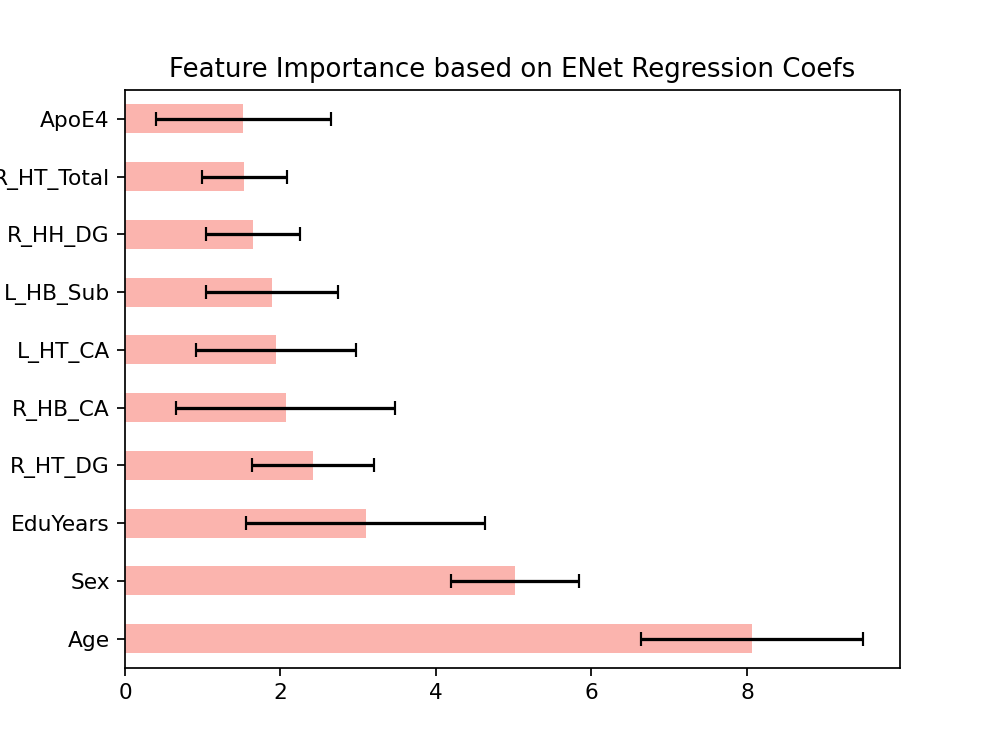

In [10]:
s = (pd.Series(coefficients_df["Feature Importance"], index=X_train.columns)).nlargest(10)
err = coefficients_df["SD Coefficient Value"][0:10]

plt.figure()
s.plot(kind='barh', xerr=err, capsize=3, colormap = 'Pastel1')
plt.title('Feature Importance based on ENet Regression Coefs')
plt.show()

<IPython.core.display.Javascript object>


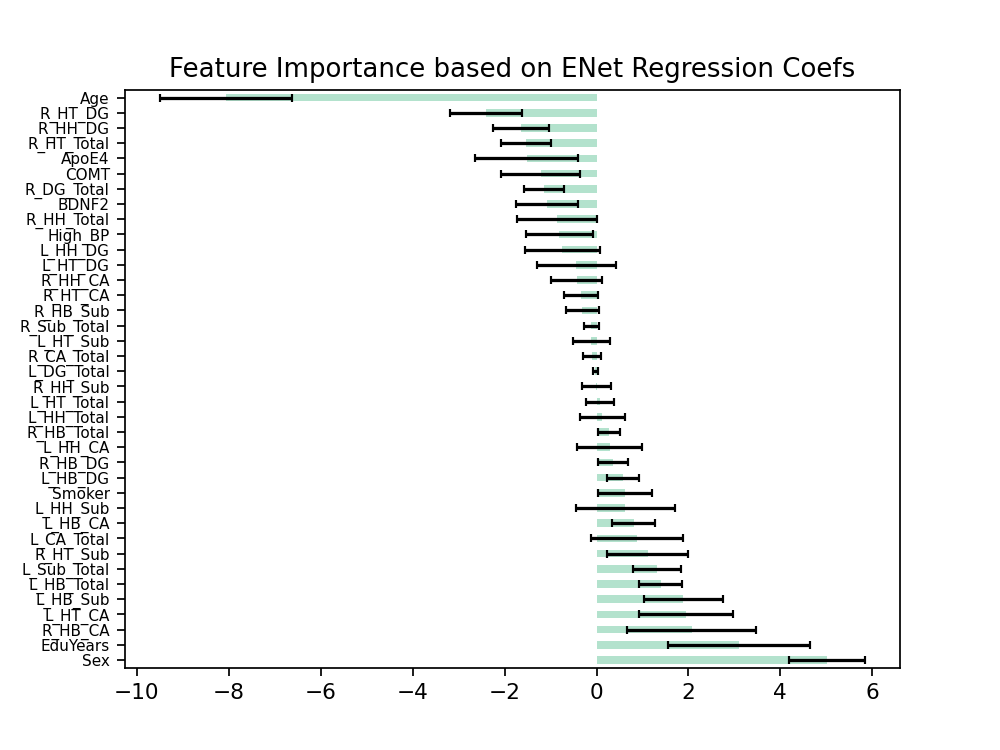

In [11]:
#Sort by mean coefs
coefficients_df = coefficients_df.sort_values(by=["Mean Coefficient Value"], ascending = False)

err = coefficients_df["SD Coefficient Value"]

plt.figure()
(pd.Series(coefficients_df["Mean Coefficient Value"])).plot(kind='barh', 
                                                            xerr = err,
                                                            capsize=2, 
                                                            colormap = 'Pastel2')
plt.yticks(fontsize=7)
plt.title('Feature Importance based on ENet Regression Coefs')
plt.show()

# Predicting Long-Delayed Free Recall

In [18]:
# Empty list to store evaluation metrics
outer_train_mae = []
outer_train_mse = []
outer_train_rmse = []
outer_train_corelation = []
outer_train_r2 = []

outer_test_mae = []
outer_test_mse = []
outer_test_rmse = []
outer_test_corelation = []
outer_test_r2 = []

coefficients_df = pd.DataFrame()


feature_names = ['Age','Sex', 'EduYears', 'Smoker', 'High_BP', 'COMT', 'BDNF2', 'ApoE4'
                 ]
target = ['CVLT_DelR_LD_Free']

# Feature Scaling
scaler = MinMaxScaler()
df[feature_names] = scaler.fit_transform(df[feature_names])

# configure the cross-validation procedure
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

#fold counter
fold_no = 1

# Loop through each outer CV fold
for train_index_outer, test_index_outer in outer_cv.split(df, df.grp):
    train_set = df.loc[train_index_outer,:]
    test_set = df.loc[test_index_outer,:]

    X_train = train_set[feature_names]
    y_train = train_set[target]
    X_test = test_set[feature_names]
    y_test = test_set[target]
    
        
    print("\n Results for outer loop fold ", fold_no)
    fold_no = fold_no+1
        
    
    #Print out memory performance to ensure similar distribution across folds
#    plt.figure()
#    plt.subplot(1, 2, 1) 
#    plt.hist(y_train, bins=10)
#    plt.hist(y_test, bins=10)
#    plt.title("Memory Score Distribution")
    
#    plt.subplot(1, 2, 2)
#    plt.hist(X_train.Age, bins=10)
#    plt.hist(X_test.Age, bins=10)
#    plt.title("Age Distribution")
#    plt.show()
    
    #Apply grid search with CV=3 on outer train_set (this is hyperparameter tuning process within the inner loop)
    search.fit(X = X_train, y = y_train) # run inner loop hyperparam tuning

    print('        Best MSE (across all inner validation folds):', abs(search.best_score_))
    print('        Best parameters:', search.best_params_)
    
    #Best model based on grid search
    best_model = search.best_estimator_
   
    #Inner Train set performance
    #This is to compare with performance on the test set and identify fitting issues
    #Predict train set
    y_train_hat = best_model.predict(X_train)
    
    #MSE
    mse_train = mean_squared_error(y_train, y_train_hat)
    outer_train_mse.append(mse_train)
    print('\n        MSE (on outer training set)', mse_train)
    
    #RMSE
    rmse_train = np.sqrt(mse_train)
    outer_train_rmse.append(rmse_train)
    print('        RMSE (on outer training set)', (outer_train_rmse[-1]))

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_hat)
    outer_train_mae.append(mae_train)          
    print('        MAE (on outer training set)', (outer_train_mae[-1]))
         
    # R2
    r2_train = r2_score(y_train, y_train_hat)
    outer_train_r2.append(r2_train)    
    print('        R2 (on outer training set)', (outer_train_r2[-1]))
    
    #Correlation between true vs predicted
    y_train_array = np.array(y_train).reshape(1,len(y_train))
    y_train_hat_array = pd.DataFrame(y_train_hat)
    y_train_hat_array = np.array(y_train_hat_array).reshape(1,len(y_train_hat))
    corelation_true_pred_train = np.corrcoef(y_train_array, y_train_hat_array)[0,1]
    outer_train_corelation.append(corelation_true_pred_train)          
    print('        Correlation between Predicted and actual values (on outer training set)', (outer_train_corelation[-1]))
    
    
    ######## EVALUATE ON OUTER TEST SET ########
    #Predict y_test based on best model
    y_test_hat = best_model.predict(X_test)
    
    # Calculate evaluation metrics using best-tuned model on the outer val_set  
    #MSE
    mse_test = mean_squared_error(y_test, y_test_hat)
    outer_test_mse.append(mse_test)
    print('\n        MSE (on outer test set)', (outer_test_mse[-1]))
    
    #RMSE
    rmse_test = np.sqrt(mse_test)
    outer_test_rmse.append(rmse_test)
    print('        RMSE (on outer test set)', (outer_test_rmse[-1]))

    # MAE
    mae_test = mean_absolute_error(y_test, y_test_hat)
    outer_test_mae.append(mae_test)          
    print('        MAE (on outer test set)', (outer_test_mae[-1]))
         
    # R2
    r2_test = r2_score(y_test, y_test_hat)
    outer_test_r2.append(r2_test)    
    print('        R2 (on outer test set)', (outer_test_r2[-1]))
    
    #Correlation between true vs predicted
    y_test_array = np.array(y_test).reshape(1,len(y_test))
    y_test_hat_array = pd.DataFrame(y_test_hat)
    y_test_hat_array = np.array(y_test_hat_array).reshape(1,len(y_test_hat))
    corelation_true_pred = np.corrcoef(y_test_array, y_test_hat_array)[0,1]
    outer_test_corelation.append(corelation_true_pred)          
    print('        Correlation between Predicted and actual values (on outer test set)', (outer_test_corelation[-1]))
    
    
    ######## COEFFICIENTS #########   
    coefficients = best_model.coef_

    #Create df column for coefficients
    column_name = 'Feature Importance '+ str(fold_no-1)
    coefficients_df[column_name] = coefficients
    
    
# Print evaluation metrics across all outer loop folds
print('\n    Average performance across all outer test sets:')
print('        MSE %.2f +/- %.2f'% (np.mean(outer_test_mse), np.std(outer_test_mse)))
print('        RMSE %.2f +/- %.2f'% (np.mean(outer_test_rmse), np.std(outer_test_rmse)))
print('        MAE %.2f +/- %.2f'% (np.mean(outer_test_mae), np.std(outer_test_mae)))
print('        R2 %.2f +/- %.2f'% (np.mean(outer_test_r2), np.std(outer_test_r2)))
print('        Correlation %.2f +/- %.2f'% (np.mean(outer_test_corelation), np.std(outer_test_corelation)))

#Feature Importance Dataframe

coefficients_df = coefficients_df.set_index(X_train.columns)
coefficients_df["Mean Coefficient Value"] = coefficients_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].mean(axis=1)
coefficients_df["SD Coefficient Value"] = coefficients_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].std(axis=1)
coefficients_df["Feature Importance"] = coefficients_df["Mean Coefficient Value"].abs()

#Sort by mean importance
coefficients_df = coefficients_df.sort_values(by=["Feature Importance"], ascending = False)
coefficients_df


 Results for outer loop fold  1
        Best MSE (across all inner validation folds): 5.415281523812502
        Best parameters: {'alpha': 0.01}

        MSE (on outer training set) 4.802695430520381
        RMSE (on outer training set) 2.1915052887274493
        MAE (on outer training set) 1.8115958629917859
        R2 (on outer training set) 0.2675972311638868
        Correlation between Predicted and actual values (on outer test set) 0.5190860137585998

        MSE (on outer test set) 5.956321809504796
        RMSE (on outer test set) 2.440557684117463
        MAE (on outer test set) 2.0486390054861308
        R2 (on outer test set) 0.19918982831637988
        Correlation between Predicted and actual values (on outer test set) 0.47585636348244525

 Results for outer loop fold  2
        Best MSE (across all inner validation folds): 5.281786176762839
        Best parameters: {'alpha': 0.03}

        MSE (on outer training set) 4.66302424957867
        RMSE (on outer training set) 2.

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Coefficient Value,SD Coefficient Value,Feature Importance
Age,-3.146709,-2.802353,-2.120707,-2.677665,-3.102627,-2.770012,0.413432,2.770012
Sex,1.660082,1.312013,1.884582,1.266463,1.694071,1.563442,0.265022,1.563442
Smoker,1.636510,0.143814,0.805348,0.384312,1.080111,0.810019,0.587604,0.810019
EduYears,0.513668,1.777786,0.623797,0.000000,0.046419,0.592334,0.717872,0.592334
COMT,-0.564642,-0.979704,-0.099259,-0.407840,-0.636927,-0.537675,0.322116,0.537675
High_BP,1.165602,0.000000,0.417251,0.000000,0.604380,0.437447,0.485078,0.437447
BDNF2,-0.576561,-0.585656,0.010007,-0.034731,-0.258468,-0.289082,0.285345,0.289082
ApoE4,-0.000000,-0.943299,-0.124564,-0.000000,-0.254093,-0.264391,0.393821,0.264391


In [12]:
# Empty list to store evaluation metrics
outer_train_mae = []
outer_train_mse = []
outer_train_rmse = []
outer_train_corelation = []
outer_train_r2 = []

outer_test_mae = []
outer_test_mse = []
outer_test_rmse = []
outer_test_corelation = []
outer_test_r2 = []

coefficients_df = pd.DataFrame()


feature_names = ['Age','Sex', 'EduYears', 'Smoker', 'High_BP', 'COMT', 'BDNF2', 'ApoE4',
                 'L_HH_Total', 'R_HH_Total', 'L_HB_Total', 'R_HB_Total', 'L_HT_Total', 'R_HT_Total',
                 'L_DG_Total', 'R_DG_Total',
                 'L_CA_Total', 'R_CA_Total',
                 'L_Sub_Total', 'R_Sub_Total',
                 'L_HH_CA', 'R_HH_CA', 'L_HB_CA', 'R_HB_CA', 'L_HT_CA', 'R_HT_CA', 
                 'L_HH_DG', 'R_HH_DG', 'L_HB_DG', 'R_HB_DG', 'L_HT_DG', 'R_HT_DG',
                 'L_HH_Sub', 'R_HH_Sub', 'L_HB_Sub', 'R_HB_Sub', 'L_HT_Sub', 'R_HT_Sub']
target = ['CVLT_DelR_LD_Free']

# Feature Scaling
scaler = MinMaxScaler()
df[feature_names] = scaler.fit_transform(df[feature_names])

# configure the cross-validation procedure
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

#fold counter
fold_no = 1

# Loop through each outer CV fold
for train_index_outer, test_index_outer in outer_cv.split(df, df.grp):
    train_set = df.loc[train_index_outer,:]
    test_set = df.loc[test_index_outer,:]

    X_train = train_set[feature_names]
    y_train = train_set[target]
    X_test = test_set[feature_names]
    y_test = test_set[target]
    
        
    print("\n Results for outer loop fold ", fold_no)
    fold_no = fold_no+1
        
    
    #Print out memory performance to ensure similar distribution across folds
#    plt.figure()
#    plt.subplot(1, 2, 1) 
#    plt.hist(y_train, bins=10)
#    plt.hist(y_test, bins=10)
#    plt.title("Memory Score Distribution")
    
#    plt.subplot(1, 2, 2)
#    plt.hist(X_train.Age, bins=10)
#    plt.hist(X_test.Age, bins=10)
#    plt.title("Age Distribution")
#    plt.show()
    
    #Apply grid search with CV=3 on outer train_set (this is hyperparameter tuning process within the inner loop)
    search.fit(X = X_train, y = y_train) # run inner loop hyperparam tuning

    print('        Best MSE (across all inner validation folds):', abs(search.best_score_))
    print('        Best parameters:', search.best_params_)
    
    #Best model based on grid search
    best_model = search.best_estimator_
   
    #Inner Train set performance
    #This is to compare with performance on the test set and identify fitting issues
    #Predict train set
    y_train_hat = best_model.predict(X_train)
    
    #MSE
    mse_train = mean_squared_error(y_train, y_train_hat)
    outer_train_mse.append(mse_train)
    print('\n        MSE (on outer training set)', mse_train)
    
    #RMSE
    rmse_train = np.sqrt(mse_train)
    outer_train_rmse.append(rmse_train)
    print('        RMSE (on outer training set)', (outer_train_rmse[-1]))

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_hat)
    outer_train_mae.append(mae_train)          
    print('        MAE (on outer training set)', (outer_train_mae[-1]))
         
    # R2
    r2_train = r2_score(y_train, y_train_hat)
    outer_train_r2.append(r2_train)    
    print('        R2 (on outer training set)', (outer_train_r2[-1]))
    
    #Correlation between true vs predicted
    y_train_array = np.array(y_train).reshape(1,len(y_train))
    y_train_hat_array = pd.DataFrame(y_train_hat)
    y_train_hat_array = np.array(y_train_hat_array).reshape(1,len(y_train_hat))
    corelation_true_pred_train = np.corrcoef(y_train_array, y_train_hat_array)[0,1]
    outer_train_corelation.append(corelation_true_pred_train)          
    print('        Correlation between Predicted and actual values (on outer test set)', (outer_train_corelation[-1]))
    
    
    ######## EVALUATE ON OUTER TEST SET ########
    #Predict y_test based on best model
    y_test_hat = best_model.predict(X_test)
    
    # Calculate evaluation metrics using best-tuned model on the outer val_set  
    #MSE
    mse_test = mean_squared_error(y_test, y_test_hat)
    outer_test_mse.append(mse_test)
    print('\n        MSE (on outer test set)', (outer_test_mse[-1]))
    
    #RMSE
    rmse_test = np.sqrt(mse_test)
    outer_test_rmse.append(rmse_test)
    print('        RMSE (on outer test set)', (outer_test_rmse[-1]))

    # MAE
    mae_test = mean_absolute_error(y_test, y_test_hat)
    outer_test_mae.append(mae_test)          
    print('        MAE (on outer test set)', (outer_test_mae[-1]))
         
    # R2
    r2_test = r2_score(y_test, y_test_hat)
    outer_test_r2.append(r2_test)    
    print('        R2 (on outer test set)', (outer_test_r2[-1]))
    
    #Correlation between true vs predicted
    y_test_array = np.array(y_test).reshape(1,len(y_test))
    y_test_hat_array = pd.DataFrame(y_test_hat)
    y_test_hat_array = np.array(y_test_hat_array).reshape(1,len(y_test_hat))
    corelation_true_pred = np.corrcoef(y_test_array, y_test_hat_array)[0,1]
    outer_test_corelation.append(corelation_true_pred)          
    print('        Correlation between Predicted and actual values (on outer test set)', (outer_test_corelation[-1]))
    
    
    ######## COEFFICIENTS #########   
    coefficients = best_model.coef_

    #Create df column for coefficients
    column_name = 'Feature Importance '+ str(fold_no-1)
    coefficients_df[column_name] = coefficients
    
    
# Print evaluation metrics across all outer loop folds
print('\n    Average performance across all outer test sets:')
print('        MSE %.2f +/- %.2f'% (np.mean(outer_test_mse), np.std(outer_test_mse)))
print('        RMSE %.2f +/- %.2f'% (np.mean(outer_test_rmse), np.std(outer_test_rmse)))
print('        MAE %.2f +/- %.2f'% (np.mean(outer_test_mae), np.std(outer_test_mae)))
print('        R2 %.2f +/- %.2f'% (np.mean(outer_test_r2), np.std(outer_test_r2)))
print('        Correlation %.2f +/- %.2f'% (np.mean(outer_test_corelation), np.std(outer_test_corelation)))


 Results for outer loop fold  1
        Best MSE (across all inner validation folds): 5.550184489349397
        Best parameters: {'alpha': 0.05}

        MSE (on outer training set) 4.521106107283925
        RMSE (on outer training set) 2.1262892811854
        MAE (on outer training set) 1.7324470202851987
        R2 (on outer training set) 0.3105391172352927
        Correlation between Predicted and actual values (on outer test set) 0.5855818909353598

        MSE (on outer test set) 7.206744083122642
        RMSE (on outer test set) 2.6845379645523066
        MAE (on outer test set) 2.3305015826561766
        R2 (on outer test set) 0.03107418452845956
        Correlation between Predicted and actual values (on outer test set) 0.2615557688348618

 Results for outer loop fold  2
        Best MSE (across all inner validation folds): 5.623477918864572
        Best parameters: {'alpha': 0.060000000000000005}

        MSE (on outer training set) 4.791026873757467
        RMSE (on outer tr

## Feature Importance

In [13]:
#Feature Importance Dataframe

coefficients_df = coefficients_df.set_index(X_train.columns)
coefficients_df["Mean Coefficient Value"] = coefficients_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].mean(axis=1)
coefficients_df["SD Coefficient Value"] = coefficients_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].std(axis=1)
coefficients_df["Feature Importance"] = coefficients_df["Mean Coefficient Value"].abs()

#Sort by mean importance
coefficients_df = coefficients_df.sort_values(by=["Feature Importance"], ascending = False)

#Print top 10 
coefficients_df[0:10]

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Coefficient Value,SD Coefficient Value,Feature Importance
Age,-1.883002,-2.193242,-1.583712,-3.362777,-1.671115,-2.138769,0.723424,2.138769
Sex,1.755686,1.150247,1.852337,1.648621,1.254733,1.532325,0.311795,1.532325
R_HH_DG,-0.431267,-0.000000,-0.872539,-2.073303,-0.000000,-0.675422,0.860948,0.675422
R_HB_DG,0.231651,0.141331,0.961156,0.867847,0.673870,0.575171,0.371015,0.575171
R_HT_DG,-0.748239,-0.425384,-0.096440,-0.277301,-0.333252,-0.376123,0.240168,0.376123
Smoker,0.065600,0.000000,0.719141,0.653531,0.304965,0.348647,0.329317,0.348647
High_BP,0.711609,0.000000,0.480865,0.474224,0.000000,0.333339,0.318955,0.333339
L_HT_DG,-0.522323,-0.063153,-0.121517,-0.925021,-0.004917,-0.327386,0.390946,0.327386
R_HH_Total,-0.018571,-0.000000,-0.839014,-0.716740,-0.000000,-0.314865,0.424943,0.314865
COMT,-0.150530,-0.745295,-0.000000,-0.259618,-0.313875,-0.293863,0.279403,0.293863


<IPython.core.display.Javascript object>


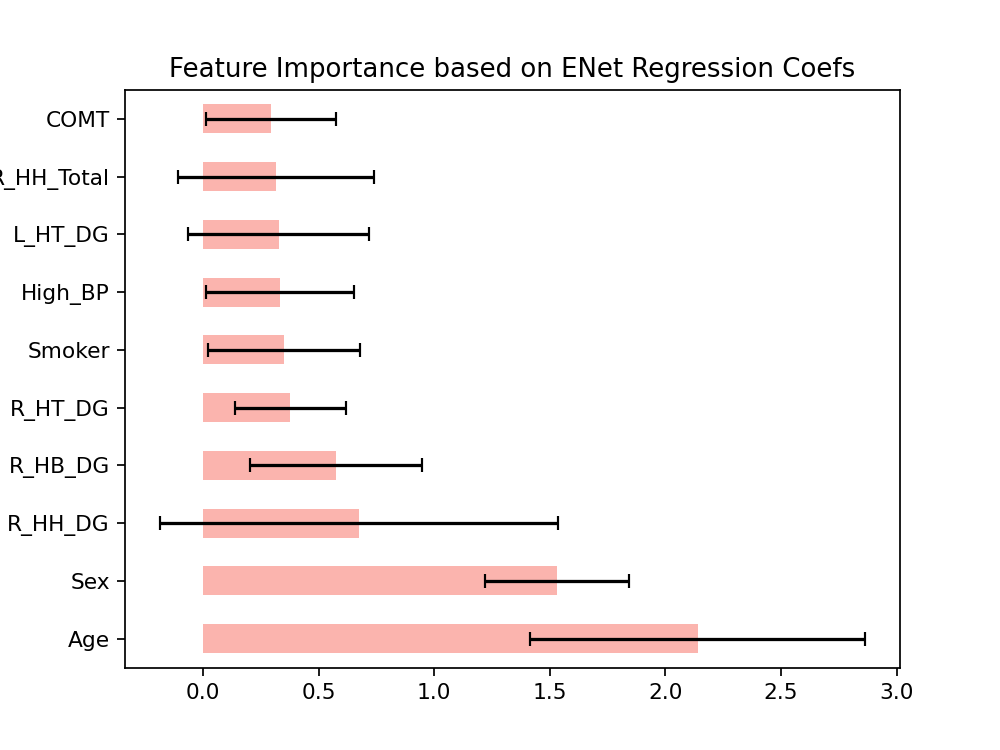

In [14]:
s = (pd.Series(coefficients_df["Feature Importance"], index=X_train.columns)).nlargest(10)
err = coefficients_df["SD Coefficient Value"][0:10]

plt.figure()
s.plot(kind='barh', xerr=err, capsize=3, colormap = 'Pastel1')
plt.title('Feature Importance based on ENet Regression Coefs')
plt.show()

<IPython.core.display.Javascript object>


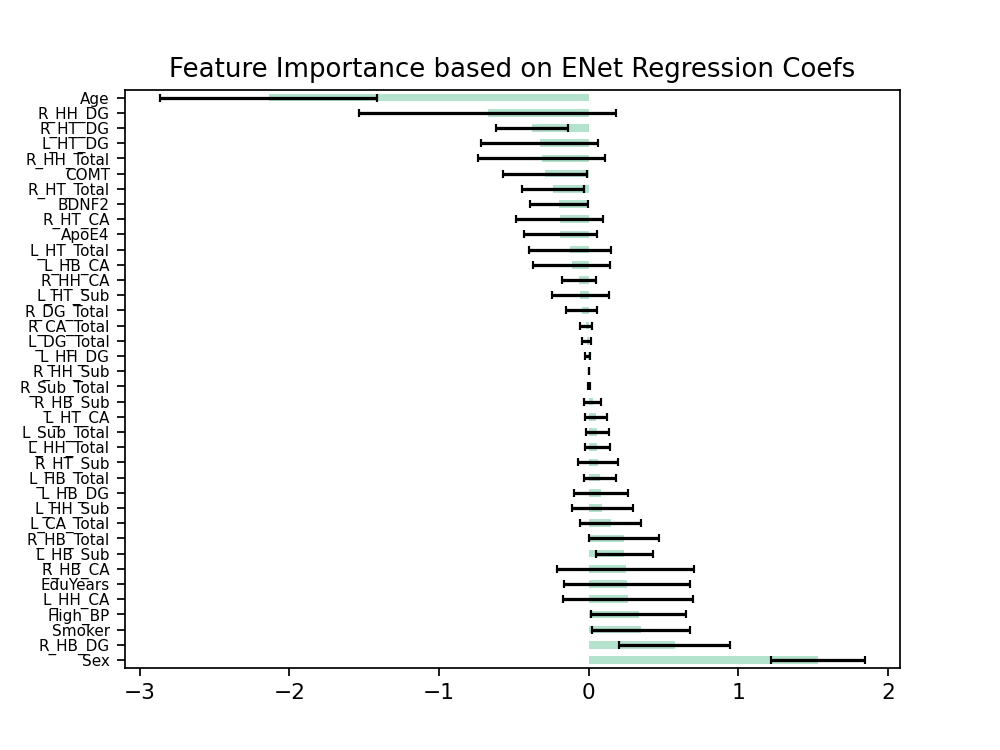

In [15]:
#Sort by mean importance
coefficients_df = coefficients_df.sort_values(by=["Mean Coefficient Value"], ascending = False)

err = coefficients_df["SD Coefficient Value"]

plt.figure()
(pd.Series(coefficients_df["Mean Coefficient Value"])).plot(kind='barh', 
                                                            xerr = err,
                                                            capsize=2, 
                                                            colormap = 'Pastel2')
plt.yticks(fontsize=7)
plt.title('Feature Importance based on ENet Regression Coefs')
plt.show()